Define a spatial axis across multiple images that do not have the same number of annotations present.

The goal here is to have a consistent spatial axis scale across multiple samples, even if a sample (ie. an image) is missing certain annotations. 

In [1]:
import sys; sys.path.append("/nfs/research/uhlmann/callum/spatial_axis/src")

In [2]:
from spatial_axis import spatial_axis
from spatial_axis.utility import (
    random_shapely_circles,
    create_broad_annotation_polygons,
)
from spatial_axis.spatial_axis import spatial_axis_to_labelmap
import matplotlib.pyplot as plt
from rasterio.features import rasterize
import geopandas
import numpy as np

In [3]:
IMG_SHAPE = (256, 256)
NUM_BROAD_ANNOTATION = 4

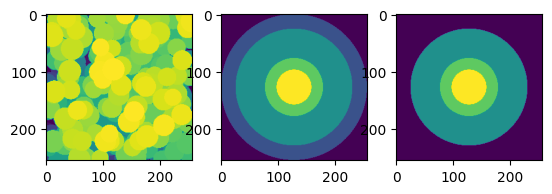

In [4]:
# Create some shapes and broad annotations

shapes = random_shapely_circles(
    image_shape=IMG_SHAPE,
    num_circles=500,
    min_radius=15,
    max_radius=20,
    seed=42,
)

labeled_shapes = [(polygon, idx + 1) for idx, polygon in enumerate(shapes)]
labeled_shapes = rasterize(
    [(poly, label) for poly, label in labeled_shapes],
    out_shape=IMG_SHAPE,
    fill=0,  # Background value
)

broad_annotations1 = create_broad_annotation_polygons(
    image_shape=IMG_SHAPE,
    annotation_shape="circle",
    num_levels=NUM_BROAD_ANNOTATION,
    downscale_factor=[0.8, 0.5, 0.6, 0.8],
)

broad_annotations2 = broad_annotations1[:]
broad_annotations2.pop(1)

labeled_broad_annotations1 = [
    (polygon, idx) for idx, polygon in enumerate(broad_annotations1)
]
labeled_broad_annotations1 = rasterize(
    [(poly, label) for poly, label in labeled_broad_annotations1],
    out_shape=IMG_SHAPE,
    fill=0,  # Background value
)

labeled_broad_annotations2 = [
    (polygon, idx) for idx, polygon in enumerate(broad_annotations2)
]
labeled_broad_annotations2 = rasterize(
    [(poly, label) for poly, label in labeled_broad_annotations2],
    out_shape=IMG_SHAPE,
    fill=0,  # Background value
)

labeled_broad_annotations2 = np.where(labeled_broad_annotations1 == 1, 0, labeled_broad_annotations1)

fig, ax = plt.subplots(1, 3)
ax[0].imshow(labeled_shapes)
ax[1].imshow(labeled_broad_annotations1)
ax[2].imshow(labeled_broad_annotations2)

In [5]:
np.unique(labeled_broad_annotations1), np.unique(labeled_broad_annotations2)

(array([0, 1, 2, 3, 4]), array([0, 2, 3, 4]))

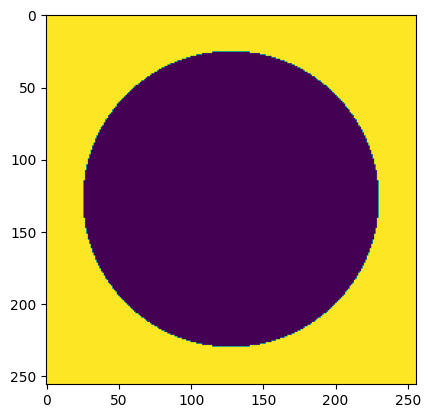

In [6]:
fig, ax = plt.subplots()
ax.imshow(np.where(labeled_broad_annotations2 == 0, 1, 0))

In [7]:
# Convert shapes polygon list to a GeoDataFrame
shapes_df = geopandas.GeoDataFrame(geometry=shapes)

# We'll use the same shapes for each spatial axis
shapes1 = shapes_df.copy()
shapes2 = shapes_df.copy()
shapes2

,geometry
0,"POLYGON ((114.542 243.383, 114.452 241.554, 11..."
1,"POLYGON ((169.037 39.941, 168.961 38.394, 168...."
2,"POLYGON ((32.875 221.741, 32.788 219.976, 32.5..."
3,"POLYGON ((201.116 5.27, 201.021 3.324, 200.735..."
4,"POLYGON ((229.014 54.359, 228.938 52.799, 228...."
...,...
495,"POLYGON ((112.291 101.42, 112.203 99.609, 111...."
496,"POLYGON ((115.659 114.866, 115.581 113.279, 11..."
497,"POLYGON ((110.918 58.181, 110.844 56.675, 110...."
498,"POLYGON ((172.58 171.062, 172.493 169.289, 172..."


Text(0.5, 0.95, 'Missing annotation method: none')

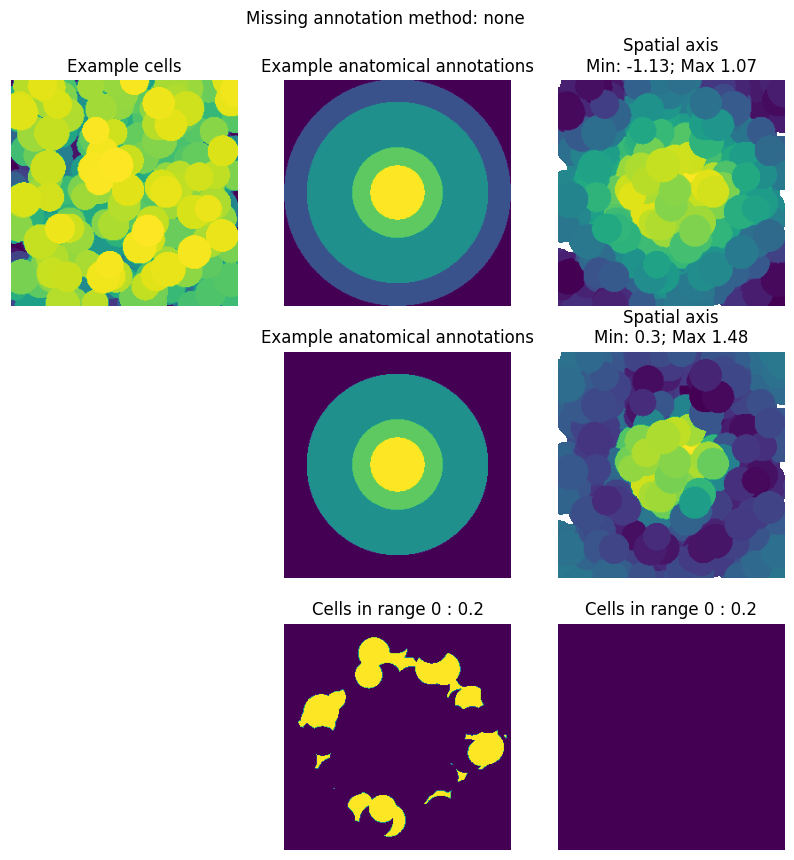

In [8]:
MISSING_ANNOTATION_METHOD = "none"

shapes1["spatial_axis"] = spatial_axis(
    shapes1, labeled_broad_annotations1, np.arange(NUM_BROAD_ANNOTATION), k_neighbours=10, missing_annotation_method=MISSING_ANNOTATION_METHOD,
    broad_annotations_to_exclude=None
)
shapes2["spatial_axis"] = spatial_axis(
    shapes2, labeled_broad_annotations2, np.arange(NUM_BROAD_ANNOTATION), k_neighbours=10, missing_annotation_method=MISSING_ANNOTATION_METHOD,
    broad_annotations_to_exclude=None
)

relative_array1 = spatial_axis_to_labelmap(shapes1, IMG_SHAPE, background_value=np.nan)
relative_array2 = spatial_axis_to_labelmap(shapes2, IMG_SHAPE, background_value=np.nan)

fig, ax = plt.subplots(3, 3, figsize=(10, 10))
ax[0, 0].imshow(labeled_shapes)
ax[0, 1].imshow(labeled_broad_annotations1)
ax[0, 2].imshow(relative_array1)
ax[0, 0].set_title("Example cells")
ax[0, 1].set_title("Example anatomical annotations")
ax[0, 2].set_title(f"Spatial axis\nMin: {np.nanmin(relative_array1).round(2)}; Max {np.nanmax(relative_array1).round(2)}")

ax[1, 1].imshow(labeled_broad_annotations2)
ax[1, 2].imshow(relative_array2)
ax[1, 1].set_title("Example anatomical annotations")
ax[1, 2].set_title(f"Spatial axis\nMin: {np.nanmin(relative_array2).round(2)}; Max {np.nanmax(relative_array2).round(2)}")

mi, ma = 0, 0.2
ax[2, 1].imshow(np.where(np.logical_and(relative_array1>=mi, relative_array1<=ma), 1, 0))
ax[2, 2].imshow(np.where(np.logical_and(relative_array2>=mi, relative_array2<=ma), 1, 0))
ax[2, 1].set_title(f"Cells in range {mi} : {ma}")
ax[2, 2].set_title(f"Cells in range {mi} : {ma}")

[_ax.axis("off") for _ax in ax.flatten()]

fig.suptitle(f"Missing annotation method: {MISSING_ANNOTATION_METHOD}", y=0.95)

1 142.28304759354992
2 142.28304759354992
1 nan
2 142.28304759354992


Text(0.5, 0.95, 'Missing annotation method: knn')

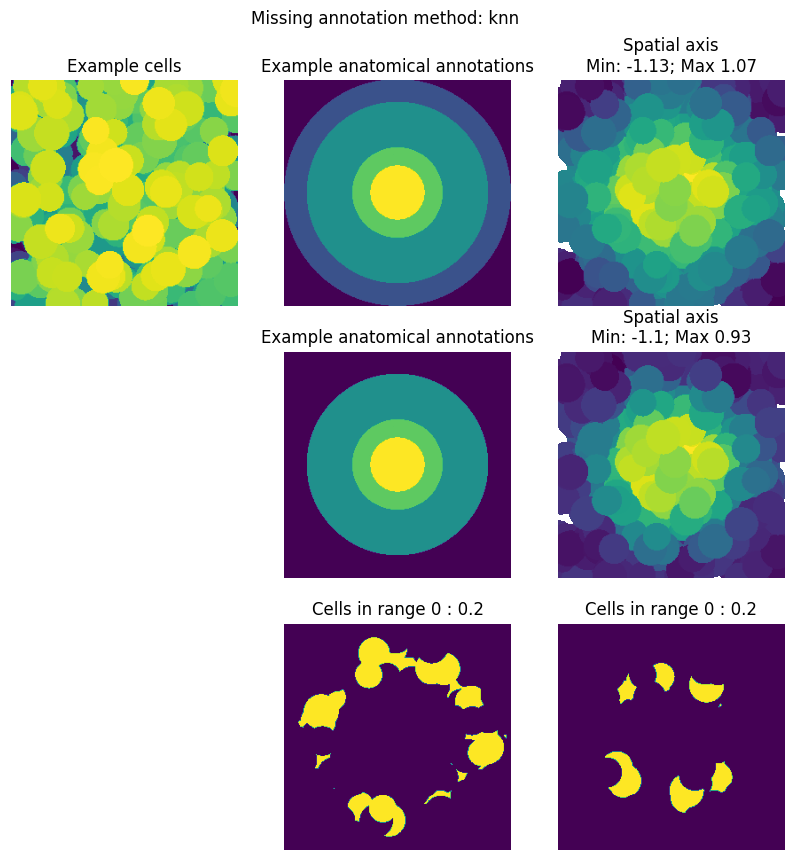

In [9]:
MISSING_ANNOTATION_METHOD = "knn"

shapes1["spatial_axis"] = spatial_axis(
    shapes1, labeled_broad_annotations1, np.arange(NUM_BROAD_ANNOTATION), k_neighbours=10, missing_annotation_method=MISSING_ANNOTATION_METHOD,
    broad_annotations_to_exclude=None
)
shapes2["spatial_axis"] = spatial_axis(
    shapes2, labeled_broad_annotations2, np.arange(NUM_BROAD_ANNOTATION), k_neighbours=10, missing_annotation_method=MISSING_ANNOTATION_METHOD,
    broad_annotations_to_exclude=None
)

relative_array1 = spatial_axis_to_labelmap(shapes1, IMG_SHAPE, background_value=np.nan)
relative_array2 = spatial_axis_to_labelmap(shapes2, IMG_SHAPE, background_value=np.nan)

fig, ax = plt.subplots(3, 3, figsize=(10, 10))
ax[0, 0].imshow(labeled_shapes)
ax[0, 1].imshow(labeled_broad_annotations1)
ax[0, 2].imshow(relative_array1)
ax[0, 0].set_title("Example cells")
ax[0, 1].set_title("Example anatomical annotations")
ax[0, 2].set_title(f"Spatial axis\nMin: {np.nanmin(relative_array1).round(2)}; Max {np.nanmax(relative_array1).round(2)}")

ax[1, 1].imshow(labeled_broad_annotations2)
ax[1, 2].imshow(relative_array2)
ax[1, 1].set_title("Example anatomical annotations")
ax[1, 2].set_title(f"Spatial axis\nMin: {np.nanmin(relative_array2).round(2)}; Max {np.nanmax(relative_array2).round(2)}")

mi, ma = 0, 0.2
ax[2, 1].imshow(np.where(np.logical_and(relative_array1>=mi, relative_array1<=ma), 1, 0))
ax[2, 2].imshow(np.where(np.logical_and(relative_array2>=mi, relative_array2<=ma), 1, 0))
ax[2, 1].set_title(f"Cells in range {mi} : {ma}")
ax[2, 2].set_title(f"Cells in range {mi} : {ma}")

[_ax.axis("off") for _ax in ax.flatten()]

fig.suptitle(f"Missing annotation method: {MISSING_ANNOTATION_METHOD}", y=0.95)

Text(0.5, 0.95, 'Missing annotation method: replace\nReplace value: 1')

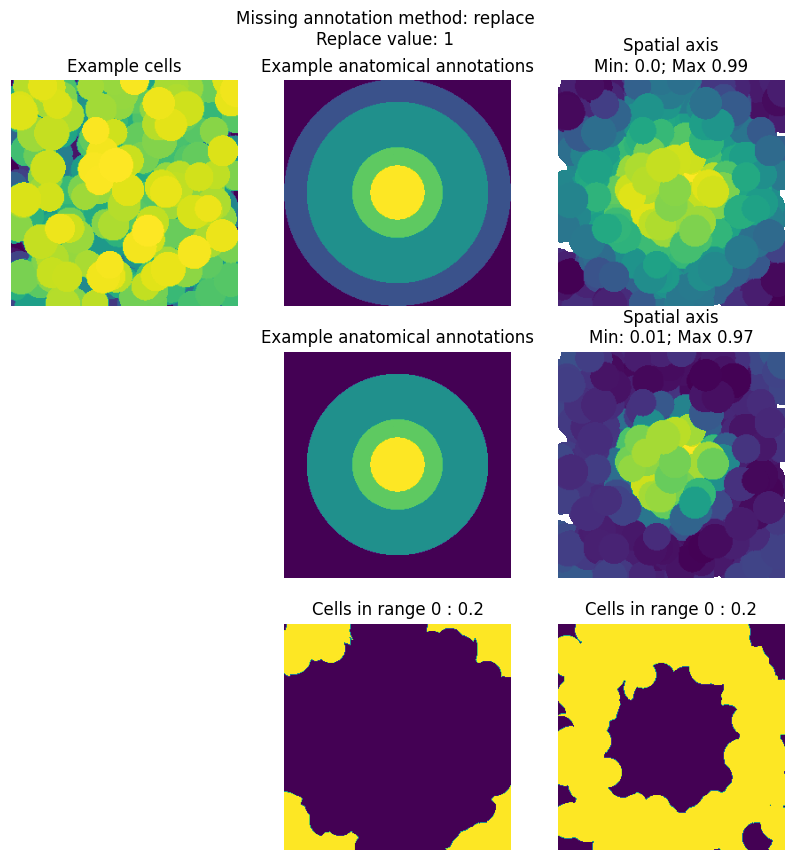

In [10]:
MISSING_ANNOTATION_METHOD = "replace"
REPLACE_VALUE = 1

shapes1["spatial_axis"] = spatial_axis(
    shapes1, labeled_broad_annotations1, np.arange(NUM_BROAD_ANNOTATION), k_neighbours=10, replace_value=REPLACE_VALUE, missing_annotation_method=MISSING_ANNOTATION_METHOD,
    broad_annotations_to_exclude=None
)
shapes2["spatial_axis"] = spatial_axis(
    shapes2, labeled_broad_annotations2, np.arange(NUM_BROAD_ANNOTATION), k_neighbours=10, replace_value=REPLACE_VALUE, missing_annotation_method=MISSING_ANNOTATION_METHOD,
    broad_annotations_to_exclude=None
)

shapes1["spatial_axis"]  = (shapes1["spatial_axis"] - shapes1["spatial_axis"].min()) / (shapes1["spatial_axis"].max() - shapes1["spatial_axis"].min())
shapes2["spatial_axis"]  = (shapes2["spatial_axis"] - shapes2["spatial_axis"].min()) / (shapes2["spatial_axis"].max() - shapes2["spatial_axis"].min())

relative_array1 = spatial_axis_to_labelmap(shapes1, IMG_SHAPE, background_value=np.nan)
relative_array2 = spatial_axis_to_labelmap(shapes2, IMG_SHAPE, background_value=np.nan)

fig, ax = plt.subplots(3, 3, figsize=(10, 10))
ax[0, 0].imshow(labeled_shapes)
ax[0, 1].imshow(labeled_broad_annotations1)
ax[0, 2].imshow(relative_array1)
ax[0, 0].set_title("Example cells")
ax[0, 1].set_title("Example anatomical annotations")
ax[0, 2].set_title(f"Spatial axis\nMin: {np.nanmin(relative_array1).round(2)}; Max {np.nanmax(relative_array1).round(2)}")

ax[1, 1].imshow(labeled_broad_annotations2)
ax[1, 2].imshow(relative_array2)
ax[1, 1].set_title("Example anatomical annotations")
ax[1, 2].set_title(f"Spatial axis\nMin: {np.nanmin(relative_array2).round(2)}; Max {np.nanmax(relative_array2).round(2)}")

mi, ma = 0, 0.2
ax[2, 1].imshow(np.where(np.logical_and(relative_array1>=mi, relative_array1<=ma), 1, 0))
ax[2, 2].imshow(np.where(np.logical_and(relative_array2>=mi, relative_array2<=ma), 1, 0))
ax[2, 1].set_title(f"Cells in range {mi} : {ma}")
ax[2, 2].set_title(f"Cells in range {mi} : {ma}")

[_ax.axis("off") for _ax in ax.flatten()]

fig.suptitle(f"Missing annotation method: {MISSING_ANNOTATION_METHOD}\nReplace value: {REPLACE_VALUE}", y=0.95)